# Long-term uncertainty

TBD: only some uncertainties included for the moment.

## Code configuration

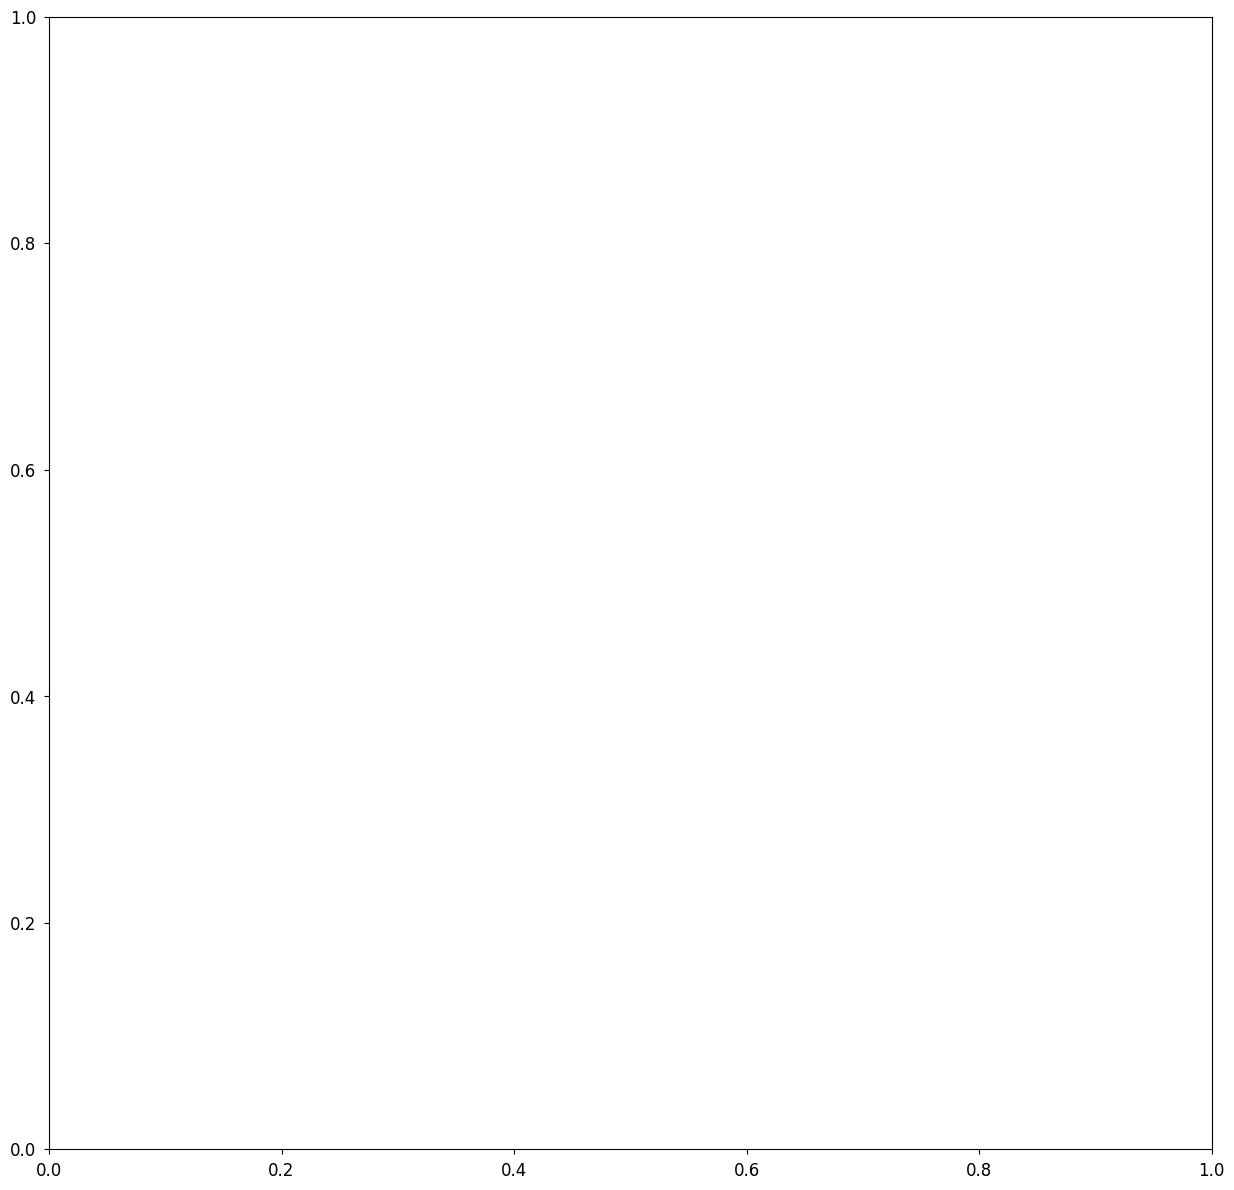

In [1]:
#standard libraries
import pandas as pd
#importing numpy to define randomstate
import numpy as np
from os import getcwd
from os.path import join, dirname
import matplotlib as mpl
import matplotlib.pyplot as plt

#ground-based solar irradiance libraries
from clear_sky import SolarLibrary
import uncertainty as unc
import irradiance_plot as iplt
import decorators

In [2]:
#retrieving stored variables
%store -r
#remove unwanted cache
%store -d spam ax
#automatically reload
%load_ext autoreload
# autoreload 0 if deactivated 2 if all modules but excluded -
%autoreload 1

In [3]:
#interrupt when needed
%aimport data_operations, decorators, pvlib, uncertainty, irradiance_plot

In [4]:
#variables from pyranometer disconnection analysis

WRAP_WIDTH = 80
pd.set_option('display.max_columns', 10)
mpl.style.use(['seaborn-paper', 'thesis'])
print(mpl.rcParams["legend.loc"])

upper right


## Long-term uncertainty CREST

### CREST setup and data loading

In [5]:
#Module position is retrieved through [digimap](#https://digimap.edina.ac.uk/)
LATITUDE = 52.7616
#negative longitude based on solar convention
LONGITUDE =  - (1.2406)
ALTITUDE = 79
PRESSURE = 101325.
TEMPERATURE = 12
DELTA_T = 67.0
ATMOS_REFRACT = 0.5667
TRANSMITTANCE = 0.5

SURFACE_ZENITH = 34
SURFACE_AZIMUTH = 180

#test sensitivities not the ones from EURAC
CREST_CMP11_05_SENSITIVITY = 8.65 / 10 ** 6
CREST_CMP11_06_SENSITIVITY = 8.8 / 10 ** 6

sl_r = SolarLibrary(latitude=LATITUDE, longitude=LONGITUDE, altitude=ALTITUDE,
                 temperature=TEMPERATURE, delta_t=DELTA_T, pressure=PRESSURE,
                  surface_zenith=SURFACE_ZENITH, surface_azimuth=SURFACE_AZIMUTH,
                  atmos_refract=ATMOS_REFRACT, transmittance=TRANSMITTANCE)

In [6]:
execute = True

In [7]:
if execute:
    ISC_IRRADIANCE_FILES_FOLDER = join(dirname(getcwd())+r"/assets/isc_irradiance_files/")
    gpoa = pd.read_csv(filepath_or_buffer=join(ISC_IRRADIANCE_FILES_FOLDER,'chpoa_y15-20.csv'))
    print(gpoa.columns)

Index(['g_cmp11_ppuk', 'tmstamp', 'date_trunc'], dtype='object')


In [8]:
if execute:
    gpoa.date_trunc = pd.to_datetime(gpoa.date_trunc, format='%d/%m/%Y %H:%M:%S')
    gpoa.index = pd.DatetimeIndex(gpoa.date_trunc, ambiguous='NaT', name="datetime")
    print(min(gpoa.index), max(gpoa.index))
    #renaming for uniformity
    gpoa.rename({"g_cmp11_ppuk":"gpoa"}, inplace=True, axis=1)

2015-01-01 00:00:00 2020-12-31 23:00:00


In [9]:
# example one year
#gpoa_15 = gpoa[gpoa.date_trunc < "2016-01-01 00:00:00"].copy(deep=True)
# gpoa > 0 to avoid getting negative irradiance
gpoa = gpoa[gpoa.gpoa > 0]


### Irradiance annual measurement uncertainty
Alignment not yet considered
also in this example specific crest orientation used for directional response

In [10]:
sdf = sl_r.getsolardataframe(gpoa.index, outputs=["zenith", "azimuth", "angleofincidence"])

In [11]:
gpoa = gpoa.merge(sdf[["zenith","azimuth", "angleofincidence"]], left_index=True, right_index=True)

In [12]:
sensor_uncertainty = unc.Irradiance_Uncertainty( method="isoa cmp11",
                                                sensitivity=CREST_CMP11_06_SENSITIVITY)

In [13]:
gpoa["pyr_azimuth"] = gpoa["azimuth"].apply(lambda x: (x+225) % 360)

In [14]:
sensor_uncertainty = unc.Irradiance_Uncertainty( method="isoa cmp11",
                                                sensitivity=CREST_CMP11_06_SENSITIVITY)
#uncertainties to be considered both for gum (and mc)
uncertainties_labels = sensor_uncertainty.uncertainties_df.index.to_list()
uncertainties_labels.remove("zero_offset_total")
uncertainties_labels.remove("alignment_zenith")
uncertainties_labels.remove("alignment_azimuth")
# 16/10/21 TBC why not using GUM if None coefficients provided ?
# 25/10/21 because for one sided distribution better MC ? TBC
# 25/10/21 using mc with None to avoid self.uncertainties_df to be used
uncs_no_mc = dict(zip(uncertainties_labels,[None]*len(uncertainties_labels )))
print(uncs_no_mc)
sensor_uncertainty.uncertainties_df

{'zero_offset_a': None, 'zero_offset_b': None, 'zero_offset_other': None, 'non_stability': None, 'non_linearity': None, 'directional_response': None, 'spectral_error': None, 'temperature_response': None, 'tilt_response': None, 'signal_processing': None, 'calibration': None, 'maintenance': None}


,acceptance_a,acceptance_b,acceptance_c,distribution,divisor,...,parameter,shape,uncertainty,unit,acceptance
uncertainty,,,,,,,,,,,
zero_offset_total,10.00,21.00,41.00,rectangular,1.732051,...,irradiance,symmetric,zero_offset_total,Wm-2,10.0
zero_offset_a,7.00,15.00,30.00,rectangular,1.732051,...,irradiance,symmetric,zero_offset_a,Wm-2,7.0
zero_offset_b,2.00,4.00,8.00,rectangular,1.732051,...,irradiance,symmetric,zero_offset_b,Wm-2,2.0
zero_offset_other,1.00,2.00,3.00,rectangular,1.732051,...,irradiance,symmetric,zero_offset_other,Wm-2,1.0
non_stability,0.80,1.50,3.00,rectangular,1.732051,...,sensitivity,symmetric,non_stability,%,0.5
non_linearity,0.50,1.00,3.00,rectangular,1.732051,...,sensitivity,symmetric,non_linearity,%,0.2
directional_response,10.00,20.00,30.00,rectangular,1.732051,...,irradiance,symmetric,directional_response,Wm-2,10.0
spectral_error,0.50,1.00,5.00,rectangular,1.732051,...,sensitivity,symmetric,spectral_error,%,0.5
temperature_response,1.00,2.00,4.00,rectangular,1.732051,...,sensitivity,symmetric,temperature_response,%,1.0


In [15]:
deviations_aoi_cf1 = sensor_uncertainty.get_uncertainty(irradiance=gpoa["gpoa"], angle_of_incidence=gpoa["angleofincidence"],
            azimuth = gpoa["pyr_azimuth"],
            coverage_factor=1, uncs_mc_cffs=uncs_no_mc)

In [16]:
# recalculated since deviation is combination of modelled directional response change plus uncertainty

deviations_aoi_cf2 = sensor_uncertainty.get_uncertainty(irradiance=gpoa["gpoa"], angle_of_incidence=gpoa["angleofincidence"],
            azimuth = gpoa["pyr_azimuth"],
            coverage_factor=2, uncs_mc_cffs=uncs_no_mc)

In [17]:
#TBC: only one calculation required since coverage factor could be multiplied after ?
#25/10/21 actually for different distribution could not simply multiply by coverage factor

deviations_cf1 = sensor_uncertainty.get_uncertainty(irradiance=gpoa["gpoa"],
            coverage_factor=1, uncs_mc_cffs=uncs_no_mc)

In [18]:
# symmetric
gpoa["year"] = gpoa["date_trunc"].apply(lambda x: x.year)
gpoa["p160"], gpoa["p840"]  = gpoa["gpoa"] + deviations_cf1, gpoa["gpoa"] - deviations_cf1
gpoa["p975"], gpoa["p025"]  = gpoa["gpoa"] + deviations_cf1*2, gpoa["gpoa"] - deviations_cf1*2
gpoa["p160_aoi"], gpoa["p840_aoi"]  = gpoa["gpoa"] + deviations_aoi_cf1, gpoa["gpoa"] - deviations_aoi_cf1
gpoa["p975_aoi"], gpoa["p025_aoi"]  = gpoa["gpoa"] + deviations_aoi_cf2, gpoa["gpoa"] - deviations_aoi_cf2

In [19]:
columns_grp = ["year", "p025", "p025_aoi", "p160", "p160_aoi", "gpoa", "p840_aoi", "p840", "p975_aoi", "p975"]
agg = dict(zip(columns_grp, [max]+[sum]*(len(columns_grp)-1)))

In [20]:
#frequency grouper not needed
#gpoa_yearly = gpoa.loc[:, columns_grp].groupby([pd.Grouper(freq='1Y', key='date_trunc')]).sum()
gpoa_yearly = gpoa.loc[:, columns_grp].groupby("year").agg(agg)

gpoa_yearly

,year,p025,p025_aoi,p160,p160_aoi,gpoa,p840_aoi,p840,p975_aoi,p975
year,,,,,,,,,,
2015,2015,9.271873e+05,9.492395e+05,1.011117e+06,1.000090e+06,983140.123,9.661898e+05,9.551637e+05,1.017041e+06,1.039093e+06
2016,2016,1.048511e+06,1.073663e+06,1.144240e+06,1.131664e+06,1112330.319,1.092997e+06,1.080420e+06,1.150997e+06,1.176150e+06
2017,2017,1.085384e+06,1.111796e+06,1.185904e+06,1.172698e+06,1152397.157,1.132096e+06,1.118891e+06,1.192999e+06,1.219410e+06
2018,2018,1.178198e+06,1.204798e+06,1.279436e+06,1.266136e+06,1245689.910,1.225244e+06,1.211944e+06,1.286582e+06,1.313182e+06
2019,2019,1.173225e+06,1.200002e+06,1.275137e+06,1.261748e+06,1241166.255,1.220584e+06,1.207195e+06,1.282331e+06,1.309108e+06
2020,2020,1.187735e+06,1.214501e+06,1.289604e+06,1.276221e+06,1255647.518,1.235074e+06,1.221691e+06,1.296794e+06,1.323560e+06


In [21]:
#percentage evaluation per year
gpoa_yearly_prc = gpoa_yearly.copy(deep=True)

for c in columns_grp:
    if c != "year" and c != "gpoa":
        gpoa_yearly_prc[c] = gpoa_yearly_prc.apply(lambda x: round((x[c]/x["gpoa"] - 1)*100, 2), axis=1)

gpoa_yearly_prc


,year,p025,p025_aoi,p160,p160_aoi,gpoa,p840_aoi,p840,p975_aoi,p975
year,,,,,,,,,,
2015,2015,-5.69,-3.45,2.85,1.72,983140.123,-1.72,-2.85,3.45,5.69
2016,2016,-5.74,-3.48,2.87,1.74,1112330.319,-1.74,-2.87,3.48,5.74
2017,2017,-5.82,-3.52,2.91,1.76,1152397.157,-1.76,-2.91,3.52,5.82
2018,2018,-5.42,-3.28,2.71,1.64,1245689.910,-1.64,-2.71,3.28,5.42
2019,2019,-5.47,-3.32,2.74,1.66,1241166.255,-1.66,-2.74,3.32,5.47
2020,2020,-5.41,-3.28,2.70,1.64,1255647.518,-1.64,-2.70,3.28,5.41


Legend: loc (0, 0), bbox_to_anchor (0, -0.8)
Irradiance uncertainty.jpg saved at C:\Users\wsfm\OneDrive - Loughborough University\_Personal_Backup\python_repositories\ground-based-solar-irradiance/outputs/figures/


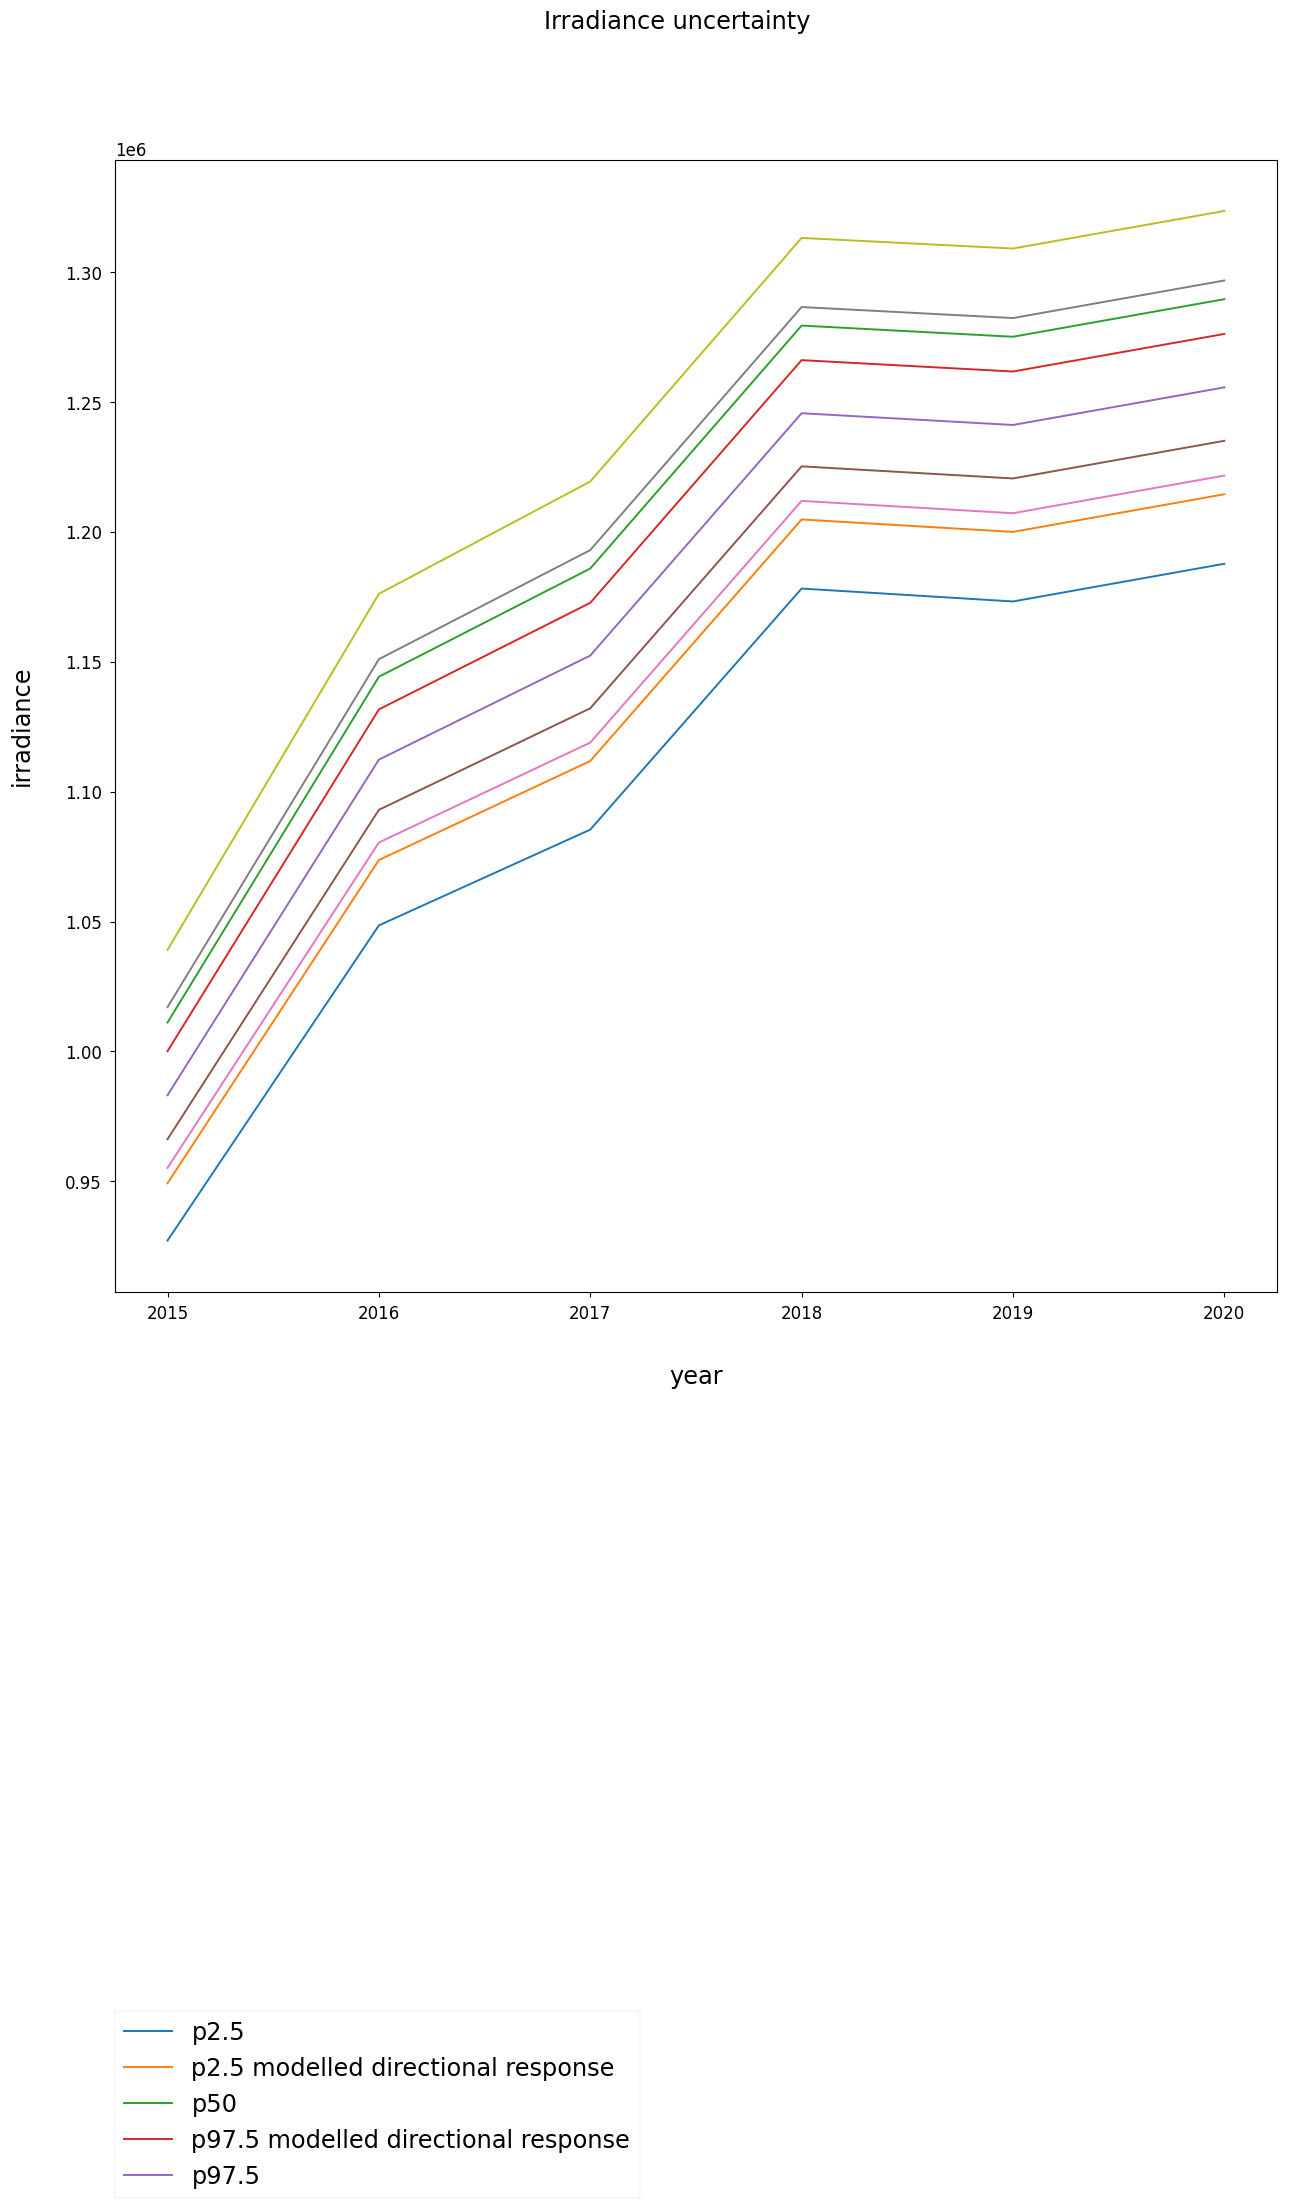

In [22]:
fig, ax = plt.subplots()
for c in columns_grp:
    #condition on which percentiles to be showed to be imposed
    if c != "year":
        ax.plot(gpoa_yearly.year, gpoa_yearly.loc[:,c])

iplt.finalise_subplots(fig, ax, fig_title= "Irradiance uncertainty",
                  lgn_labels = ["p2.5", "p2.5 modelled directional response", "p50", "p97.5 modelled directional response", "p97.5"],
                       xlabel="year", ylabel="irradiance", bbox_to_anchor=(0,-0.8))
    #, bbox_to_anchor=(0,-0.1)) #, loc=0)
#, plt_prm='', bbox_to_anchor=LGN_BBOX_TO_ANCHOR, loc=LGN_LOC)

### Irradiance long-term uncertainty

Sources for long-term uncertainty to be reviewed
To be checked:
- if and how sensitivity coefficient to be used
- if really percentage
- if suitable also for CREST situation, e.g. some model for Bolzano
- replacing previous sources with original paper sources if possible


G. Belluardo, M. Herz, U. Jahn, M. Richter, and D. Moser, “Evaluation of uncertainty in PV project design
 : definition of scenarios and impact on energy yield predictions,” 2017.

Müller, Björn Hardt, Laura Armbruster, Alfons Kiefer, Klaus Reise, Christian
Yield predictions for photovoltaic power plants: empirical validation, recent advances and remaining uncertainties
SOURCES PROVIDED

Table III. Estimated uncertainties and uncertainty contributions for a yield prediction of a typical crystalline
silicon PV system in a moderate (middle European) climate.



In [23]:
yield_uncertainty = unc.Irradiance_Uncertainty(sensitivity=None)


In [24]:
#for testing purpose using irradiance as parameter for all instead of power 


INSOLATION_VARIABILITY_5Y={'uncertainty':'insolation_variability','parameter':'irradiance','distribution':'normal',
                           'shape':'symmetric','divisor':1,'unit':'%','acceptance':9}
#19/9/21 Solar resource calculated for the first year
# calculated for the entire period although maybe average could be considered
SOLAR_RESOURCE_AOI= {'uncertainty':'solar_resource_aoi','parameter':'irradiance','distribution':'normal',
                     'shape':'symmetric','divisor':1,'unit':'%',
                         'acceptance':round((gpoa_yearly.loc[2015,"p160_aoi"]/gpoa_yearly.loc[2015,"gpoa"] - 1)*100, 2)}

SOLAR_RESOURCE = {'uncertainty':'solar_resource','parameter':'irradiance','distribution':'normal',
                     'shape':'symmetric','divisor':1,'unit':'%',
                     'acceptance':round((gpoa_yearly.loc[2015,"p160"]/gpoa_yearly.loc[2015,"gpoa"] - 1)*100, 2)}

In [25]:
#for testing purpose using irradiance as parameter for all instead of irradiance 

# TRANSPOSITION MODEL NOT NEEDED
# Notes: it is true that long-term simulation are done with gpoa but nothing prevent to do them with POA actually

# AMBIENT_TEMPERATURE_VARIABILITY_5Y could be estimated from CREST available data

#best fitting 0.14, exemplary simulation 1, bad fitting 1;15
TEMPERATURE_EFFECT =  {'uncertainty':'temperature_effect','parameter':'irradiance','distribution':'normal',
                     'shape':'symmetric','divisor':1,'unit':'%',
                     'acceptance':1}

# negative only, period to be checked. lowest value in accord with Nikol's thesis
# long-term not included in one year
PERFORMANCE_LOSS = {'uncertainty':'performance_loss','parameter':'irradiance','distribution':'normal',
                     'shape':'negative','divisor':1,'unit':'%',
                     'acceptance':0.5}

# low uncertainty minor issue in Lboro and experimental research system
SOILING = {'uncertainty':'soiling','parameter':'irradiance','distribution':'normal',
                     'shape':'negative','divisor':1,'unit':'%',
                     'acceptance':0.5}

# SHADING EFFECT not considered

REFLECTION_MISMATCH = {'uncertainty':'reflection_mismatch','parameter':'irradiance','distribution':'normal',
                     'shape':'symmetric','divisor':1,'unit':'%',
                     'acceptance':0.2}

NOMINAL_POWER = {'uncertainty':'nominal_irradiance','parameter':'irradiance','distribution':'normal',
                     'shape':'symmetric','divisor':1,'unit':'%',
                     'acceptance':0.98}

INVERTER_EFFICIENCY = {'uncertainty':'inverter_efficiency','parameter':'irradiance','distribution':'normal',
                     'shape':'symmetric','divisor':1,'unit':'%',
                     'acceptance':0.2}

# DC cabling not considered
# Power limitation not considered
# Transformer not considered
# System behaviour 

In [35]:
yield_df = pd.DataFrame()

yield_uncertainties_df = pd.DataFrame()

yield_uncertainties = [SOLAR_RESOURCE_AOI, SOLAR_RESOURCE, TEMPERATURE_EFFECT,
                     PERFORMANCE_LOSS, SOILING, REFLECTION_MISMATCH, NOMINAL_POWER, INVERTER_EFFICIENCY]

for value in list(yield_uncertainties ):
    yield_uncertainties_df=yield_uncertainties_df.append(value,ignore_index=True)
#DEV NOTE 26/9/21 index not column used for uncertainty type
yield_uncertainties_df.index = yield_uncertainties_df.loc[:,"uncertainty"]

#showing uncertainty_df
# 6/11/21 only irradiance-dependant uncertainty provided
yield_uncertainties_df

,acceptance,distribution,divisor,parameter,shape,uncertainty,unit
uncertainty,,,,,,,
solar_resource_aoi,1.72,normal,1.0,irradiance,symmetric,solar_resource_aoi,%
solar_resource,2.85,normal,1.0,irradiance,symmetric,solar_resource,%
temperature_effect,1.00,normal,1.0,irradiance,symmetric,temperature_effect,%
performance_loss,0.50,normal,1.0,irradiance,negative,performance_loss,%
soiling,0.50,normal,1.0,irradiance,negative,soiling,%
reflection_mismatch,0.20,normal,1.0,irradiance,symmetric,reflection_mismatch,%
nominal_irradiance,0.98,normal,1.0,irradiance,symmetric,nominal_irradiance,%
inverter_efficiency,0.20,normal,1.0,irradiance,symmetric,inverter_efficiency,%


In [ ]:
yield_uncertainty.uncertainties_df = yield_uncertainties_df

yield_uncertainty_labels_y1 = yield_uncertainties_df.uncertainty.to_list()
yield_uncertainty_labels_y1.remove("solar_resource_aoi")
yield_uncertainty_labels_y1.remove("performance_loss")

yield_uncertainty_labels_y1_aoi = yield_uncertainties_df.uncertainty.to_list()
yield_uncertainty_labels_y1_aoi.remove("solar_resource")
yield_uncertainty_labels_y1_aoi.remove("performance_loss")

In [34]:
yield_uncertainty.sensitivity

In [28]:
randomstate = np.random.RandomState(210829)
percentiles = [10, 50, 90]

simulations = 100
#mc not needed for calibration uncertainty since function and cofficients known

irradiance = pd.Series(gpoa_yearly.loc[2015,"gpoa"])

deviations_mc_y1 = yield_uncertainty.get_uncertainty_mc(randomstate=randomstate,
                                                                  irradiance=irradiance, coverage_factor=None,
                                                                  simulations=simulations, percentile=percentiles,
                                                                  uncertainties_labels=yield_uncertainty_labels_y1,
                                                                  angle_of_incidence=None)


deviations_mc_y1

,10,50,90
0,-41422.829599,-3367.697334,36456.998669


yield vs yield in reference period used in IEA-PVPS T13-12:2018

In [29]:
years = len(gpoa["year"].unique())
ylabels = ["p10","p50","p90"]
pv_yield_y1 = irradiance.values[0]

pv_yield = pd.DataFrame()
pv_yield["year"] = gpoa["year"].unique()
pv_yield.set_index(keys="year", drop=True, inplace=True)
# DEV NOTE 26/9/21 formatting of p100 could be done

devs_y1 = {}

l = "dev_y1_"
for k,v in dict(zip(ylabels,[str(c) for c in percentiles])).items():
    pv_yield[l+k] = [deviations_mc_y1.loc[:,v][0]] * years
    devs_y1[k]=l+k
    #pv_yield[k] = 1 + pv_yield[l+k] / pv_yield_y1
    #pv_yield[k] = [1 + deviations_mc_y1.loc[:,v][0] / pv_yield_y1 ] * years
pv_yield

,dev_y1_p10,dev_y1_p50,dev_y1_p90
year,,,
2015,-41422.829599,-3367.697334,36456.998669
2016,-41422.829599,-3367.697334,36456.998669
2017,-41422.829599,-3367.697334,36456.998669
2018,-41422.829599,-3367.697334,36456.998669
2019,-41422.829599,-3367.697334,36456.998669
2020,-41422.829599,-3367.697334,36456.998669


Legend: loc (0, 0), bbox_to_anchor (0, -0.2)
Final yield uncertainty.jpg saved at C:\Users\wsfm\OneDrive - Loughborough University\_Personal_Backup\python_repositories\ground-based-solar-irradiance/outputs/figures/


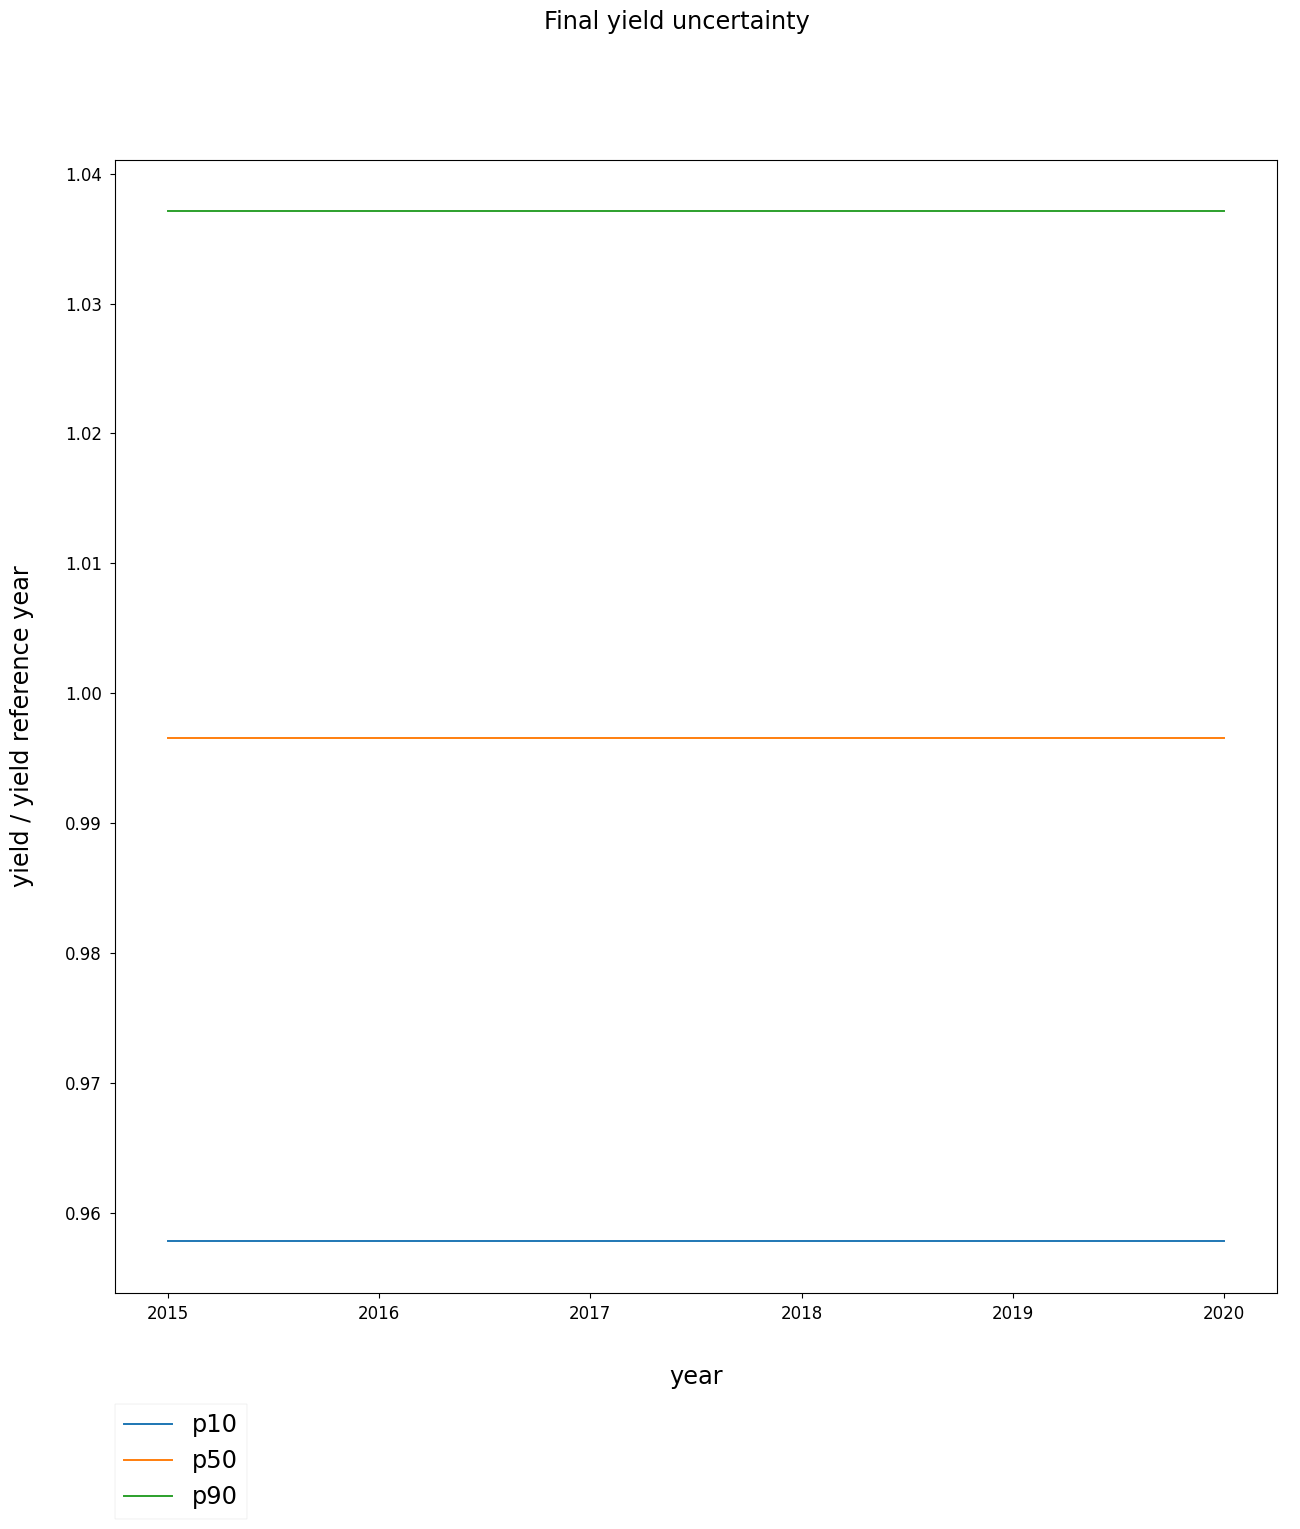

In [30]:
# 6/11/21 add absolute irradiance on the parasite axis

fig, ax = plt.subplots()
for c in [v for v in devs_y1.values()]:
    #condition on which percentiles to be showed to be imposed
    ax.plot(pv_yield.index, 1 + pv_yield.loc[:,c] / pv_yield_y1)

iplt.finalise_subplots(fig, ax, fig_title= "Final yield uncertainty",
                  lgn_labels = ylabels,
                       xlabel="year", ylabel="yield / yield reference year", bbox_to_anchor=(0,-0.2))

In [31]:
#long-term deviations
l = "dev_lt_"
# assing deviation first year to all years. Long-term deviation will be cumulated after
pv_yield[[l+p for p in ylabels]] = pv_yield[["dev_y1_"+p for p in ylabels]]
for y in pv_yield.index.to_list():
    deviations_mc_lt = yield_uncertainty.get_uncertainty_mc(randomstate=randomstate,
                                                                  irradiance=irradiance, coverage_factor=None,
                                                                  simulations=simulations, percentile=percentiles,
                                                                  uncertainties_labels=["performance_loss"],
                                                                  angle_of_incidence=None)
    for k,v in dict(zip(ylabels,[str(c) for c in percentiles])).items():
        # adding long-term deviation. Small contribution comparing to existing one.
        pv_yield.loc[pv_yield.index >= y,l+k] += deviations_mc_lt.loc[:,v][0]

pv_yield

,dev_y1_p10,dev_y1_p50,dev_y1_p90,dev_lt_p10,dev_lt_p50,dev_lt_p90
year,,,,,,
2015,-41422.829599,-3367.697334,36456.998669,-47669.701941,-2824.512416,43615.733475
2016,-41422.829599,-3367.697334,36456.998669,-52089.899934,-2443.545619,48709.382452
2017,-41422.829599,-3367.697334,36456.998669,-57030.179052,-1612.792215,54744.879667
2018,-41422.829599,-3367.697334,36456.998669,-62987.025057,-29.936617,61343.716173
2019,-41422.829599,-3367.697334,36456.998669,-68816.554416,-433.024067,66360.680220
2020,-41422.829599,-3367.697334,36456.998669,-75096.853522,56.088144,72883.814936


Legend: loc (0, 0), bbox_to_anchor (0, -0.2)
Final yield uncertainty long-term.jpg saved at C:\Users\wsfm\OneDrive - Loughborough University\_Personal_Backup\python_repositories\ground-based-solar-irradiance/outputs/figures/


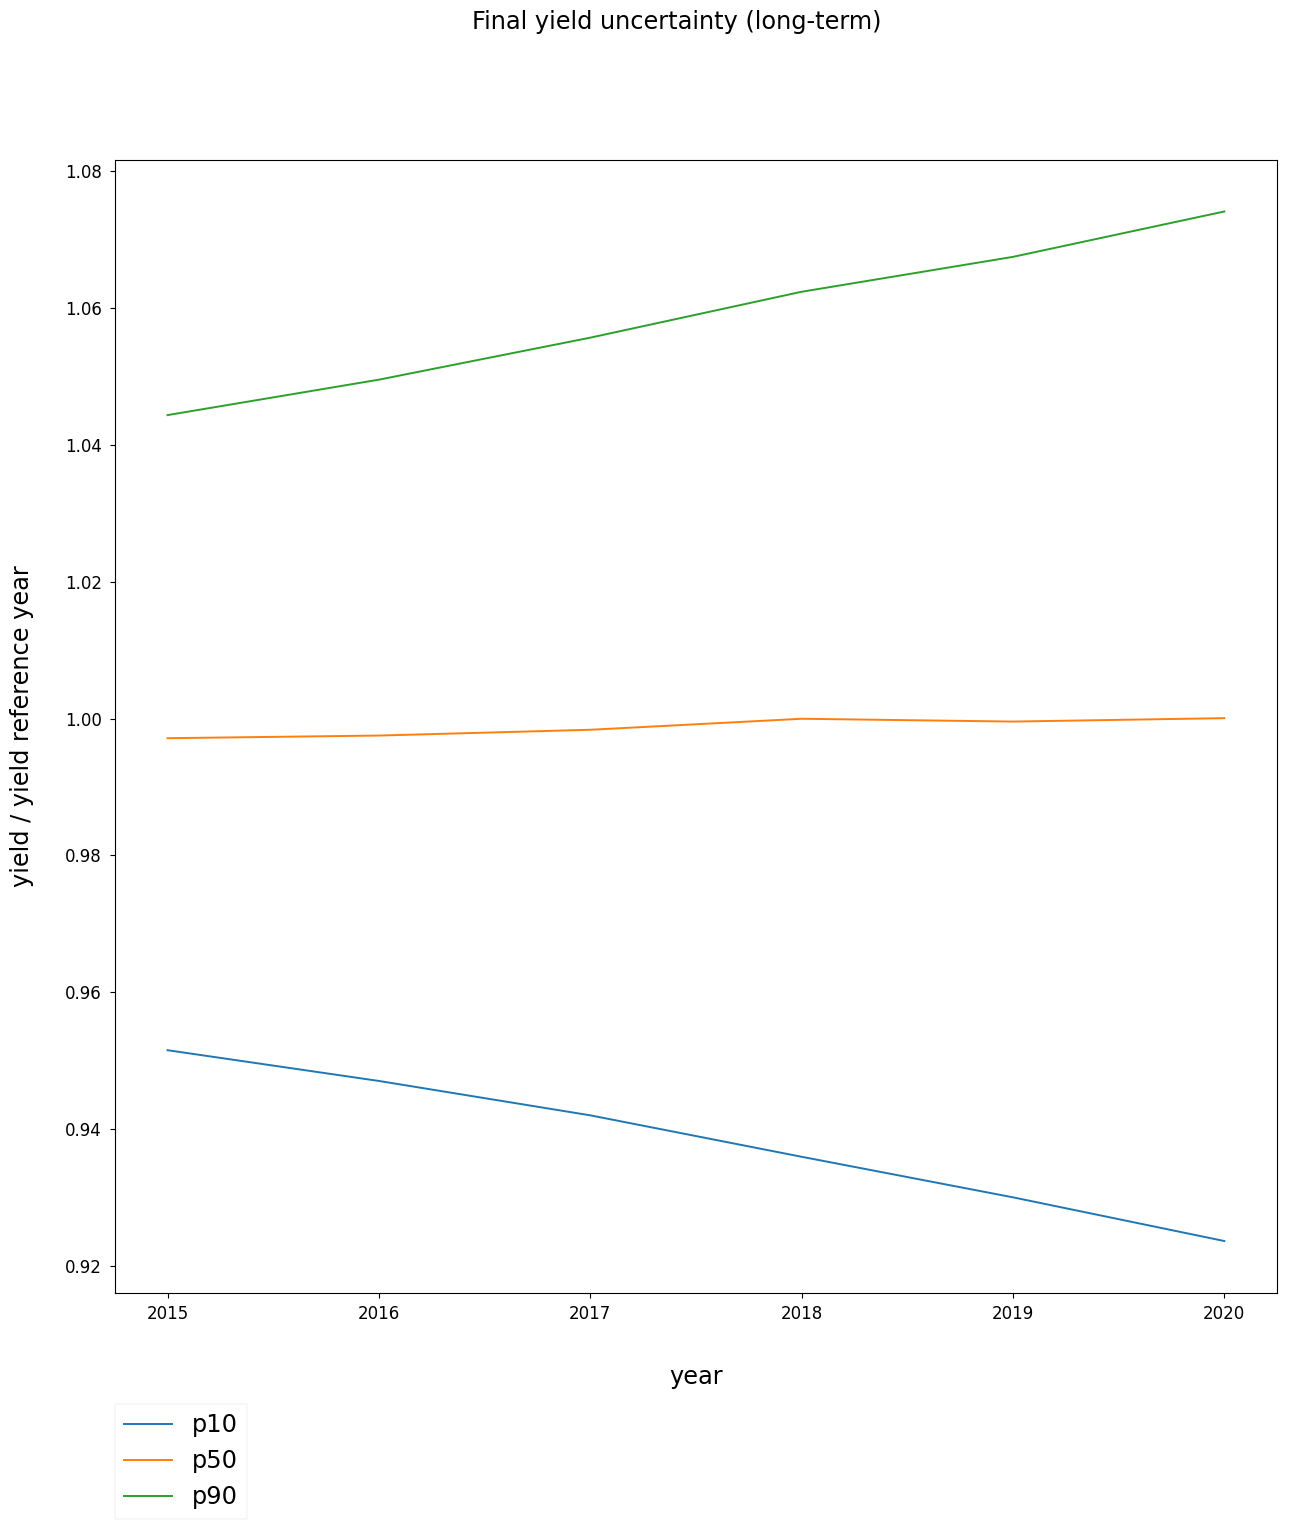

In [32]:
fig, ax = plt.subplots()
for c in [c for c in pv_yield.columns.to_list() if l in c]:
    #condition on which percentiles to be showed to be imposed
    ax.plot(pv_yield.index, 1 + pv_yield.loc[:,c] / pv_yield_y1)

iplt.finalise_subplots(fig, ax, fig_title= "Final yield uncertainty (long-term)",
                  lgn_labels = ylabels,
                       xlabel="year", ylabel="yield / yield reference year", bbox_to_anchor=(0,-0.2))

### Intrannual variability

Could be calculate from CREST data if necessary ?

Reference approach was from (IEEE conference paper):
**G. Belluardo, M. Herz, U. Jahn, M. Richter, and D. Moser, “Evaluation of uncertainty in PV project design
 : definition of scenarios and impact on energy yield predictions,” 2017.**

Reference values from Solar Bankability report (not paper):
**Jahn, Ulrike   Moser, David Richter, Mauricio
Minimizing Technical Risks in Photovoltaic Projects Recommendations for Minimizing Technical Risks of
PV Project Development and PV Plant Operation**
For Bolzano 9% uncertainty used not clear how estimated.

Uncertainty analysis previously carried in another Solar Bankability report:
**Moser, David    Del Buono, Matteo   Bresciani, Walter   Veronese, Elisa Jahn, Ulrike    Herz, Magnus
Janknecht, Eckart   Ndrio, Erin     De Brabandere, Karel    Richter, Mauricio
Technical Risks in PV Projects
Report on Technical Risks in PV Project Development and PV Plant Operation**

**Definition of annual insolation variability**
The annual insolation variability or “year-to-year variability” is defined as the ratio of the standard deviation (σ)
to the average global horizontal irradiation (GHI) over a long-term period (typically more than 10 years)
(K. Scharmer and J. Greif, 2000), (Richter et al., 2015).
In average, the standard deviation of the yearly sums of GHI is mostly in the range of 4% to 6% as shown for example,
by (Richter et al., 2015) and (Suri et al., 2007).

Table 9 presents an overview of the variability (σ) of GHI as extracted from Meteonorm (METEOTEST Genossenschaft, 2014)
for some representative weather stations located across Europe. The 90% exceedance probability (P90 scenario) is also provided.
The σ90 in Table 9 is calculated by multiplying σ with 1.328,
i.e. the conversion factor between the standard deviation and a single-sided P90 deviation considering
a Student’s t-distribution with a sample size of 20 years (period covered by the irradiation database).

Table 9: Variability of the annual GHI for different sites in Europe (20 years)
No data for Bolzano. Method description

###